<a href="https://colab.research.google.com/github/nhrishi/1.1.0-experimental_bin/blob/master/TradingIntel_v0_5_retraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_ta
!pip install fyers_apiv3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=c6f5eb5e20a67559adb10118ee5a7583145bce7e797e0bcfdcf6204b79397c39
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import relu, tanh, sigmoid

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import json as json

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
from fyers_apiv3 import fyersModel

client_id = "Q9Y3IP8H5W-100"
#access_token = "eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJhcGkuZnllcnMuaW4iLCJpYXQiOjE3MTc5MDU4OTIsImV4cCI6MTcxNzk3OTQ1MiwibmJmIjoxNzE3OTA1ODkyLCJhdWQiOlsieDowIiwieDoxIiwieDoyIiwiZDoxIiwiZDoyIiwieDoxIiwieDowIl0sInN1YiI6ImFjY2Vzc190b2tlbiIsImF0X2hhc2giOiJnQUFBQUFCbVpTbms3VGE2ektjb2ZuQlVMRjFQV05KbGI3UkJYZGVtaWlMV3pIcDlQdnRDdVJjYWRRUExSeWNZLTZBb2pFazRvZDhHNTNnVk9iWS1rX0diYk5JTVQ5LTZMcnBkODRiTjVDQ2RPTktvWWxJd0tzaz0iLCJkaXNwbGF5X25hbWUiOiJIUklTSElLRVNIIERFRVBBSyBOQVNISUtLQVIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIzMDI1Y2IzMjkxYWEzYTcyMzM3MWIyYzkxOGU4YTc5ZDFkZDk5ODlmMmI3NjcwY2ViZGZkNjQyNiIsImZ5X2lkIjoiWUgwMTc3NSIsImFwcFR5cGUiOjEwMCwicG9hX2ZsYWciOiJOIn0.xguoXythWsSY5p8GrebQbkdp8qXVRMZa0m0agds9YJc"
#access_token = "eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJhcGkuZnllcnMuaW4iLCJpYXQiOjE3MTgxMjc1NTIsImV4cCI6MTcxODE1MjIxMiwibmJmIjoxNzE4MTI3NTUyLCJhdWQiOlsieDowIiwieDoxIiwieDoyIiwiZDoxIiwiZDoyIiwieDoxIiwieDowIl0sInN1YiI6ImFjY2Vzc190b2tlbiIsImF0X2hhc2giOiJnQUFBQUFCbWFJdkF0X053Z1NxUThpME9SU2RTdnptV21YOFJSYV9DRWd3b3ZMTm9uXzJwT21oSlY2VzRHNFdxNUExblI5YnEwbmJaMjZEbVhjZTYtQVhIcTBEVkFDR0V6YlFHSjlVYmdTanRpMzZiZldnYktxTT0iLCJkaXNwbGF5X25hbWUiOiJIUklTSElLRVNIIERFRVBBSyBOQVNISUtLQVIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIzMDI1Y2IzMjkxYWEzYTcyMzM3MWIyYzkxOGU4YTc5ZDFkZDk5ODlmMmI3NjcwY2ViZGZkNjQyNiIsImZ5X2lkIjoiWUgwMTc3NSIsImFwcFR5cGUiOjEwMCwicG9hX2ZsYWciOiJOIn0.nAmIcXO_skFI-GUb4d0cPnerqPsLn0iAnLVbPTwZaMI"
access_token = "eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJhcGkuZnllcnMuaW4iLCJpYXQiOjE3Mzg1MDYwODEsImV4cCI6MTczODU0MjYyMSwibmJmIjoxNzM4NTA2MDgxLCJhdWQiOlsieDowIiwieDoxIiwieDoyIiwiZDoxIiwiZDoyIiwieDoxIiwieDowIl0sInN1YiI6ImFjY2Vzc190b2tlbiIsImF0X2hhc2giOiJnQUFBQUFCbm4zOWhCUnFaZC0yM053ZDdZSU54ZnJwcFNKQXlHQUpjYWZlTzFHT19famlKczRVQzFhem1Hd1ZxOWo3NFBLTEhWMThQVDJCMXNtWVpybzlBZVF6SGZZNVRJTGF6Tzhuek5FLThETW85RXlyUnVlcz0iLCJkaXNwbGF5X25hbWUiOiJIUklTSElLRVNIIERFRVBBSyBOQVNISUtLQVIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIzMDI1Y2IzMjkxYWEzYTcyMzM3MWIyYzkxOGU4YTc5ZDFkZDk5ODlmMmI3NjcwY2ViZGZkNjQyNiIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiWUgwMTc3NSIsImFwcFR5cGUiOjEwMCwicG9hX2ZsYWciOiJOIn0.7zbMdCaiAHtrmEPdkN7_Mi3S46GZfMe4IlKdO4RH9qk"
fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")

#yyyy-mm-dd
daily_data = {
    "symbol":"MCX:SILVERMIC25FEBFUT",
    "resolution":"60",
    "date_format":"1",
    "range_from":"2024-11-01",
    "range_to":"2025-01-31",
    "cont_flag":"1"
}

response = fyers.history(data=daily_data)
print(response)
daily_data_json = json.dumps(response)
daily_data_df = json.loads(daily_data_json)
#print(daily_data_df['candles'])
pricing_daily_data = daily_data_df['candles']
daily_df = pd.DataFrame(pricing_daily_data)
daily_df.columns = ["epoch", "open", "high", "low", "close", "volume"]

# #hourly data Extraction
# hourly_data = {
#     "symbol":"NSE:SBIN-EQ",
#     "resolution":"60",
#     "date_format":"1",
#     "range_from":"2024-03-01",
#     "range_to":"2024-05-29",
#     "cont_flag":"1"
# }

import datetime
daily_df['date'] = pd.to_datetime(daily_df['epoch'], unit='s').dt.strftime('%Y-%m-%d')
print(daily_df)


{'code': -50, 'data': {'range_to': 'range_to cannot be 100 days greater than range_from for resolutions 1, 2, 3, 5, 10, 15, 20, 30, 45, 60, 120, 180 and 240'}, 'message': 'Invalid input', 's': 'error'}


KeyError: 'candles'

In [ ]:
# Moving Average 20
daily_df['DAILY_RSI']=ta.rsi(daily_df.close, length=15)
daily_df['DAILY_EMA5']=ta.ema(daily_df.close, length=5)
# daily_df['DAILY_EMA12']=ta.ema(daily_df.close, length=12)
# daily_df['DAILY_EMA13']=ta.ema(daily_df.close, length=13)
# daily_df['DAILY_EMA26']=ta.ema(daily_df.close, length=26)
daily_df['DAILY_EMA50']=ta.ema(daily_df.close, length=50)

# Calculate MACD (the difference between 12-period EMA and 26-period EMA)
daily_df['DAILY_MACD'] = daily_df['DAILY_EMA5'] - daily_df['DAILY_EMA50']

# Calculate the 9-period EMA of MACD (Signal Line)
daily_df['DAILY_SIGNAL'] = daily_df['DAILY_MACD'].ewm(span=9, adjust=False).mean()

## Target calculation
daily_df['Target'] = daily_df['close'].shift(-1) - daily_df['close']  # Price Movement
# daily_df['Target'] = daily_df['Target'].shift(-1)

daily_df['TargetClass'] = [1 if daily_df.Target[i]>0 else 0 for i in range(len(daily_df))]
daily_df['TargetNextClose'] = daily_df['close'].shift(-1)

##ADX
adx_df = daily_df.ta.adx(high=daily_df['high'], low=daily_df['low'], close=daily_df['close']);
daily_df = pd.concat([daily_df, adx_df], axis=1)

##BB
bb_df = ta.bbands(daily_df.close, length=20, std=2).iloc[:, :3]
daily_df = pd.concat([daily_df, bb_df], axis=1)

#### Drop rows with NaN values created by indicators calculation

daily_df.dropna(inplace=True)
print(daily_df.shape)

(118, 21)


In [ ]:
features = ['close', 'DAILY_MACD', 'DAILY_RSI', 'DAILY_SIGNAL', 'volume', 'DAILY_EMA5', 'DAILY_EMA50', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'Target', 'TargetClass', 'TargetNextClose', 'ADX_14']
# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_df[features])
print(scaled_data.shape)

(118, 14)


In [ ]:
# Create sequences for LSTM model
def create_sequences(data, seq_length, pred_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length - pred_length + 1):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length:i + seq_length + pred_length, 0])  # Assuming 'Close' is the first column
    return np.array(sequences), np.array(labels)

# If the input data is not a 2D array, reshape it
if len(scaled_data.shape) != 2:
    scaled_data = scaled_data.reshape(-1, 1)

SEQ_LENGTH = 5  # 60 days sequence
PRED_LENGTH = 1  # Prediction length

X, y = create_sequences(scaled_data, SEQ_LENGTH, PRED_LENGTH)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(90, 5, 14)
(90, 1)
(23, 5, 14)
(23, 1)


In [ ]:
# model = Sequential([
#     LSTM(150, activation='tanh', return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
# #    BatchNormalization(),
#     Dropout(0.2),
#     LSTM(150, activation='tanh', return_sequences=True),
#     Dropout(0.2),
#     LSTM(150, activation='tanh'),
#     Dropout(0.2),
#     Dense(PRED_LENGTH, activation='linear')
# ])

from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Colab Notebooks/models/my_silver_model05.keras")

model.compile(optimizer='adam', loss='mean_squared_error')
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - loss: 0.2076 - val_loss: 0.0217
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0441 - val_loss: 0.0419
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0514 - val_loss: 0.0097
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0319 - val_loss: 0.0264
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0391 - val_loss: 0.0102
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0276 - val_loss: 0.0065
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0285 - val_loss: 0.0074
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0240 - val_loss: 0.0052
Epoch 9/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0226 - val_loss: 0.0110
Epoch 10/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0241 - val_loss: 0.0077
Epoch 11/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0188 - val_loss: 0.0044
Epoch 12/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0202 - val_loss: 0.0045


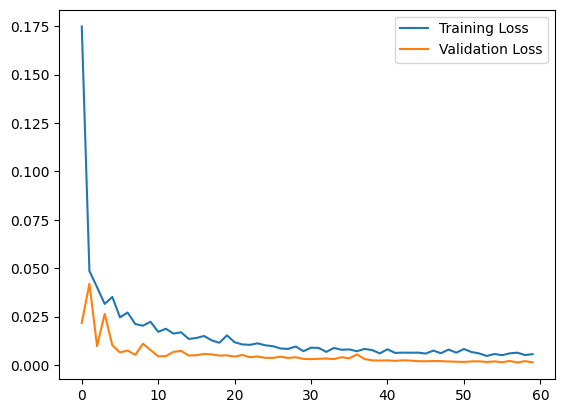

X_test (23, 5, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


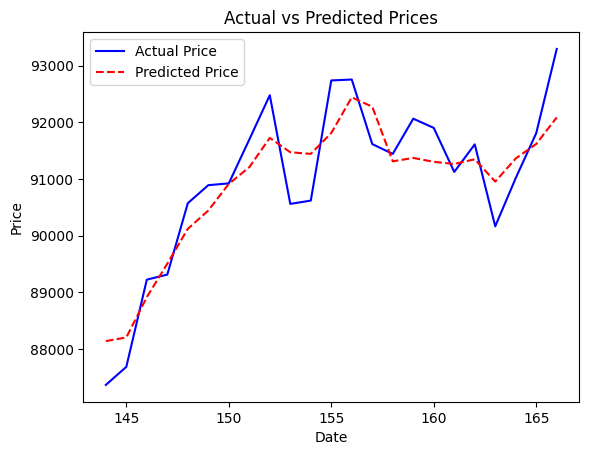

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

print("X_test", X_test.shape)

# Make predictions
test_predictions = model.predict(X_test)

test_predictions_reshaped = np.zeros((test_predictions.shape[0], scaled_data.shape[1]))
test_predictions_reshaped[:, 0] = test_predictions[:, 0]  # Only 'Close' prices are predicted
test_predictions_inversed = scaler.inverse_transform(test_predictions_reshaped)[:, 0]
# Plot predicted vs actual prices
plt.plot(daily_df.index[-len(y_test):], scaler.inverse_transform(np.concatenate([y_test, np.zeros((y_test.shape[0], scaled_data.shape[1] - y_test.shape[1]))], axis=1))[:, 0], color='blue', label='Actual Price')

plt.plot(daily_df.index[-len(test_predictions):], test_predictions_inversed, color='red', linestyle='--', label='Predicted Price')

# Adding titles and labels
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Import the os module
import os


from google.colab import drive
drive.mount('/content/drive')

# Define the directory where you want to save the model
save_dir = "/content/drive/MyDrive/Colab Notebooks/models"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model to the specified directory
model.save(os.path.join(save_dir, "my_silver_model05.keras"))


In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model("my_silver_model05.keras")  # Load your saved model


# Function to make predictions iteratively
def predict_next_days(model, recent_data, num_days=1): # Default num_days to 1
    current_sequence = recent_data
    current_sequence_reshaped = np.reshape(current_sequence, (1, current_sequence.shape[0], current_sequence.shape[1]))
    next_prediction = model.predict(current_sequence_reshaped)[0]  # Predict for the next day
    return next_prediction # Return the single prediction

# Define thresholds for low, medium, and high movement (adjust as needed)
low_threshold = 0.01  # 1%
high_threshold = 0.03  # 3%

# Predict for the next day
recent_data = scaled_data[-SEQ_LENGTH:]  # Recent data for prediction
predicted_next_day = predict_next_days(model, recent_data)  # Predict for only one day

# Reshape and inverse transform to get the actual price movement
predicted_next_day_reshaped = np.zeros((1, scaled_data.shape[1]))
predicted_next_day_reshaped[:, 0] = predicted_next_day[0]
predicted_movement = scaler.inverse_transform(predicted_next_day_reshaped)[0, 0]

# Categorize the movement and calculate percentage change
last_close_price = daily_df['close'].iloc[-1]
percentage_change = (predicted_movement / last_close_price) * 100

if abs(percentage_change) < low_threshold:
    movement_category = "Low"
elif abs(percentage_change) < high_threshold:
    movement_category = "Medium"
else:
    movement_category = "High"

print(f"Predicted Movement: {movement_category}")
print(f"Percentage Change: {percentage_change:.2f}%")

if predicted_movement > 0:
    print("Upside Movement")
else:
    print("Downside Movement")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Predicted Movement: High
Percentage Change: 99.27%
Upside Movement
